Created on Fri Mar  3 20:03:23 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.3 更新策略

## 3.3.1 1维度权重决策、复杂网络更新和2维度布局优化

In [242]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload 
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 
from usda import datasets as usda_datasets
from usda import data_visualization as usda_vis
from usda import pattern_signature as usda_signature
from usda import utils as usda_utils
from usda import meta_heuristics as usda_heuristicsw
from usda import network as usda_network

import mapclassify
import numpy  as np
import cc3d
import copy
import matplotlib.pyplot as plt
import random
import itertools
import networkx as nx
from networkx.algorithms import approximation as approx
import math
from toolz import partition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3.3.1.1 1维度权重决策

在“权重决策”一章，对于 BWM 和 IDOCRIW方法分别采用了GWO 和 GA 元启发式算法求解方程组。元启发式算法（优化算法）通常用于存在许多可能解决方案（多备选方案）的多变量（多准则）问题中，并且结果会根据这些变量的组合不同发生较大的变化。优化算法通过评分（由约束条件（constraints）给出）许多不同的解决方案确定它们的质量（对评分结果进行排序）来找到问题的最佳答案（题解）。优化算法通常用于由于解决的方案太多而无法全部遍历尝试的情况<sup>[Segaran, T. Programming Collective Intelligence. (O’Reilly, 2007).]</sup>。 Toby Segaran <sup>[Segaran, T. (2007)]</sup>提供了多个解释优化算法的案例，其中学生宿舍优化问题为根据人们的偏好分配有限资源的问题，如果延申该问题至城市空间规划领域，可以提出根据不同建设内容分配有限不同土地资源条件问题，例如根据约束条件设置，假设考虑到绿地、水体、生活服务、美食购物、教育培训、交通，建设成本等条件，存在5类不同条件的地块，

1. 地块A，绿地水体面积占比大，但其它条件偏弱，建设成本高；
2. 地块B，绿地水体面积占比偏中，有丰富的教育资源，交通条件良好，但生活服务、美食购物条件差，建设成本高；
3. 地块C，绿地水体面积占比偏中，生活服务、美食购物和交通条件好，但缺少教育资源，建设成本高；
4. 地块D，绿地少，无水体，无教育资源，但生活服务、美食购物和交通条件好，建设成本高中；
5. 地块E，裸地，建设成本低，除交通外，无其它资源。

对应变量为`plots`。

根据调研，地块A、B和C均有1个区域可选择，地块D和E有2个区域可选择，总共可选择区域数为7个，正好对应7个建设项目，每个建设项目给出首选和次选两个选择（对应变量为`prefs`），这很有可能发生用地配置冲突，那么如何协调分配，尽可能满足各建设项目的需求，面对存在多种甚至无数种解的问题，优化算法为从这些答案中寻找最优解提供了思路。

解决此问题的关键是，每个项目只能对应到一个地块区域和成本如何计算（定义目标函数）。Toby Segaran 在解决此问题时，给出了一个巧妙地解决思路，对于第1个问题，7个项目在选择地块时，采取逐一选择的策略，即第1个项目选择了一个地块后，随即将该地块从列表`plots_idx`下移除，那么第2个项目选择时仅从剩余的地块中选择。此时，优化的“权重”列表（chromosome），实际上为用于选择剩余地块列表的索引值，这也解释了参数`domain`“权重”值区间的设定为什么为`[(0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]`。对于第1个项目，此时有7个地块可以选择，因此区间均为`(0,6)`，而到第2个项目时，因为已经由第1个项目选择排除了一个，因此区间为`(0,5)`，以此类推。对于第2个问题，如果项目选择的地块为首选地块，则成本为0；如果为次选地块，则成本为1；如果均不在首选和次选中，则成本为3，因此成本值越小越趋于最优解。

In [5]:
plots=['p_a','p_b','p_c','p_d','p_e']
prefs=[('s_1',('p_d','p_c')),
       ('s_2',('p_a','p_e')),
       ('s_3',('p_a','p_e')),
       ('s_4',('p_b','p_a')),
       ('s_5',('p_d','p_b')),
       ('s_6',('p_c','p_e')),
       ('s_7',('p_e','p_b'))]

domain=[(0,7-i-1) for i in range(0,7)]
print(domain)

# 构建目标函数
def target_function_plot_allocation(vec):
    cost=0
    plots_idx=[0,1,2,3,3,4,4]
    for i in range(len(vec)):
        x=int(vec[i])
        plot=plots[plots_idx[x]]
        pref=prefs[i][1]
        if pref[0]==plot: cost+=0
        elif pref[1]==plot: cost+=1
        else: cost+=3
        
        del plots_idx[x]
    
    return cost

best_score,epoch=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_plot_allocation,popsize=20,maxiter=100,verbose=20)

[(0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]
iter_0: cost=6
iter_20: cost=1
iter_40: cost=1
iter_60: cost=1
iter_80: cost=1


打印对应迭代成本变化曲线。对于该实验，因为涉及的数据量小，快速收敛。

因为优化算法是趋于最优解，种群（population）的初始化，变异（mutation）和交叉（crossover）或配对（breeding）都应用了随机数生成随机基因（gene）的染色体（chromosome），筛选部分种群变异，从精英选拔（elitism）的染色体中随机选择父类通过交叉获取子类等过程，因此不同执行优化过程结果可能不同。

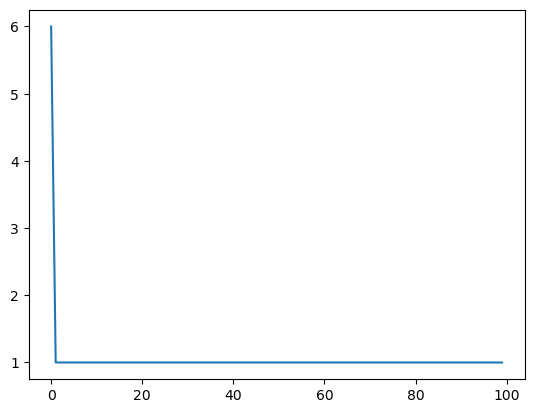

In [6]:
fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

因为“权重”列表为选择剩余地块的索引值，因此需要将计算结果返回为各个项目实际选择的地块。从上述计算结果看，7个项目中有6个保持了首选，有1个为次选，为一个不错的优化计算结果，能够满足绝大多项目的最佳需求。

In [7]:
def print_solution(vec):
    slots=[0,1,2,3,3,4,4]
    # Loop over each students assignment
    for i in range(len(vec)):
        x=int(vec[i])
        # Choose the slot from the remaining ones
        plot=plots[slots[x]]
        
        if plot in prefs[i][1]:
            priority=prefs[i][1].index(plot)
        else:
            priority=-1
        # Show the student and assigned dorm
        print (f'{prefs[i][0]}: {plot}; priority: {priority}')
        # Remove this slot
        del slots[x]
        
print(best_score)  
print('-'*50)
print_solution(best_score)

[3, 4, 0, 0, 1, 0, 0]
--------------------------------------------------
s_1: p_d; priority: 0
s_2: p_e; priority: 1
s_3: p_a; priority: 0
s_4: p_b; priority: 0
s_5: p_d; priority: 0
s_6: p_c; priority: 0
s_7: p_e; priority: 0


根据解决问题的不同，在保持遗传算法基本思想不变的条件下，涉及到的选择、变异和交叉等具体内容时，会根据具体问题相应变化。Toby Segaran 提供的上述代码变异部分为对随机一个染色体的基因执行变化，如果该基因值大于给定区间（`domain`）最小值，且生成的[0,1]随机数小于0.5，则减去`step`步幅值；如果该基因值小于给定区间最大值则加上`step`步幅值。步幅值`step`根据“权重”配置确定，例如本例“权重”为地块选择索引值，因此配置值为1。交叉部分的方法根据随机一个整数值（区间为0到“权重”列表长度，即染色体的长度）交换染色体前后部分。在*权重决策*部分给出的遗传算法，为 Valdecy Pereira 就 MCDM 问题给出的适合解法，在选择、变异和交叉等计算上保持遗传算法基本思想不变条件下，与 Toby Segaran 提供的方法不同，具体可以查看*权重决策*部分的解释。 

虽然 Toby Segaran 和 Valdecy Pereira 提供的遗传算法具体计算方式有所差异，核心仍旧是根据目标函数（计算成本值）寻找最优解的过程，因此将选择分配问题也以 Valdecy Pereira 提供的方法进行计算，参数的配置保持相同，虽然返回值为浮点数（可以调整原代码，转换为整数形式，适合此次问题形式），但取其整数后，其结果与 Toby Segaran 结果同（需要注意不同次运行优化算法，可能结果不同）。

In [18]:
domain_min=[i[0] for i in domain]
domain_max=[i[1] for i in domain]
best_score_2,epoch_2=usda_heuristicsw.genetic_algorithm(population_size=20,
                                                        mutation_rate=0.2,
                                                        elite=4,
                                                        min_values=domain_min,
                                                        max_values=domain_max,
                                                        generations=100,
                                                        target_function=target_function_plot_allocation,
                                                        verbose=20)

Generation =  0  f(x) =  1.0
Generation =  20  f(x) =  1.0
Generation =  40  f(x) =  1.0
Generation =  60  f(x) =  1.0
Generation =  80  f(x) =  1.0
Generation =  100  f(x) =  1.0


In [23]:
print(best_score_2[:-1])  
print('-'*50)
print_solution(best_score_2[:-1])

[3.43977778 4.38075696 0.14946282 0.43850957 1.08662738 0.11878839
 0.        ]
--------------------------------------------------
s_1: p_d; priority: 0
s_2: p_e; priority: 1
s_3: p_a; priority: 0
s_4: p_b; priority: 0
s_5: p_d; priority: 0
s_6: p_c; priority: 0
s_7: p_e; priority: 0


### 3.3.1.2 复杂网络更新

Toby Segaran 提供的“绘制网络”的实验，虽然其目的是为了可视化网络结构时，避免绘制边线的交叉，但是由此可以拓展到复杂网络应用元启发式算法，在约束条件控制下，生成或更新网络的方法。这里给出一个探索性实验，将廊道和斑块（节点
）的结构关系表述为复杂网络的形式，通过给定约束条件，1， 连通性；2，传递性；3，最近邻指数（点分布）；4. 避免边交叉，来生成一个根据约束条件可调的复杂网络形态。该实验分两个阶段，第1阶段为生成图；第2阶段为布局图。

#### 1) 生成图（廊道的连通性和传递性）

如果廊道具有较高的连通性（各个斑块之间有路线联系），斑块或节点之间形成环路或存在可替代路线，那么物种可以在廊道中有效移动，且避免廊道间隙、干扰、捕食者或者狩猎者的负面影响，提高移动效率<sup>[Weiss, J. Landscape Ecology Principles In Landscape Architecture And Land Use Planning. in (2016).]</sup>。对应连通性和环路，在*图属性的基本度量*一章提到``NetworkX`库的`node_connectivity`方法可以计算顶点连通度（断开网络需要移除的最少边数）；`transitivity`方法可以计算传递性（为三角形（triangle）占三元（triads，为共享顶点的两个边）的比例）。生成图的思路借鉴了“学生宿舍优化问题”，基本流程为：

1. 通过指定顶点数`nodes_n`，生成顶点（名称）列表`ndoes`，进而构建全部可成对的边`pairs`列表；
2. 指定生成图的边数`edges_n`，根据边数构建索引值区间（“权重”取值范围）`domain`，方法同“学生宿舍优化问题”，只是从全部可成对的边`pairs`列表中选择部分边，例如下述实验边列表有36个边，而提取的边数为12；
3. 构建目标函数。根据提取的边构建图`G`，计算图的连通性和传递性，并通过分别被最大潜在连通性和值1减，将最大问题转换为最小问题；
4. 在连通性和传递性的贡献度分配上，增加了一个[0,1]区间的参数`w`来调整哪个指数具有更高的影响。

为了方便构建`target_function_network()`目标函数，一般先随机生成一个随机值（本例为索引值）列表`edges_idx`，用于传入函数调试代码。

In [128]:
nodes_n=9
edges_n=12
w=0.7

complete_G=nx.complete_graph(nodes_n)
connectivity_complete=approx.node_connectivity(complete_G)
print(connectivity_complete)

nodes=[f'n_{i}' for i in range(nodes_n)]
pairs=list(itertools.combinations(nodes,2))
print(len(pairs)) 

domain=[(0,len(pairs)-i-1) for i in range(edges_n)]
print(domain)
edges_idx=[random.randint(i[0],i[1]) for i in domain] # 用于辅助构建目标函数而生成的随机“权重”值

# 构建目标函数
def target_function_network(edges_idx):
    global pairs,connectivity_complete,w

    pairs_copy=copy.deepcopy(pairs)    
    edges=[]
    for i in range(len(edges_idx)):
        x=int(edges_idx[i])
        pair=pairs_copy[x]
        edges.append(pair)
        del pairs_copy[x]

    G=nx.Graph()
    G.add_edges_from(edges)   
    connectivity_=(connectivity_complete-approx.node_connectivity(G))/connectivity_complete
    transitivity_=1-nx.transitivity(G)
    
    cost=connectivity_*w+transitivity_*(1-w)

    return cost

cost=target_function_network(edges_idx)    
print(cost)

8
36
[(0, 35), (0, 34), (0, 33), (0, 32), (0, 31), (0, 30), (0, 29), (0, 28), (0, 27), (0, 26), (0, 25), (0, 24)]
0.7431818181818182


使用遗传算法寻找最优解。

In [149]:
best_idx_1,_=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_network,step=1,popsize=50,maxiter=501,verbose=100)

iter_0: cost=0.6449999999999999
iter_100: cost=0.5923387096774193
iter_200: cost=0.5923387096774193
iter_300: cost=0.5923387096774193
iter_400: cost=0.5923387096774193
iter_500: cost=0.5923387096774193


最优解为索引值列表，需要将其转换回对应的边，并构建图，打印图查看结果。

node connectivity=3;
transitivity=0.4838709677419355


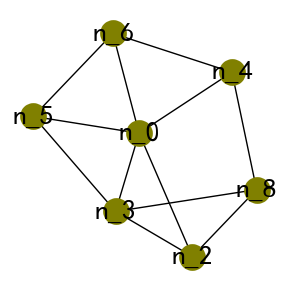

In [150]:
def show_G_solution(best_idx):
    global pairs

    pairs_copy=copy.deepcopy(pairs)    
    edges=[]
    for i in range(len(best_idx)):
        x=int(best_idx[i])
        pair=pairs_copy[x]
        edges.append(pair)
        
        del pairs_copy[x]
        
    G=nx.Graph()
    G.add_edges_from(edges)
    print(f'node connectivity={approx.node_connectivity(G)};\ntransitivity={nx.transitivity(G)}')
    usda_network.G_drawing(G)
    
    return G
    
G_1=show_G_solution(best_idx_1)

同样使用了 Valdecy Pereira 提供的遗传算法生成图，转换索引、打印查看图。

In [169]:
domain_min=[i[0] for i in domain]
domain_max=[i[1] for i in domain]
best_idx_2,_=usda_heuristicsw.genetic_algorithm(
    population_size=50,
    mutation_rate=0.2,
    elite=8,
    min_values=domain_min,
    max_values=domain_max,
    generations=500,
    target_function=target_function_network,
    verbose=100)

Generation =  0  f(x) =  0.6916666666666667
Generation =  100  f(x) =  0.5006578947368421
Generation =  200  f(x) =  0.5006578947368421
Generation =  300  f(x) =  0.45
Generation =  400  f(x) =  0.45
Generation =  500  f(x) =  0.45


node connectivity=1;
transitivity=0.6


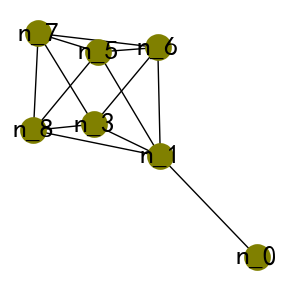

In [179]:
G_2=show_G_solution(best_idx_2)

#### 2)  布局图（最近邻指数和避免廊道交叉）

生成的图具有顶点和边，但是还没有为顶点指定地理空间位置。确定位置坐标的约束条件给了两个，一个是最近邻指数；再者为避免廊道交叉。

最近邻指数（Nearest Neighbor Index，NNI），计算各个点与其最近点的距离之和除以点数量，求得一个平均距离。如果该平均距离小于假设随机分布的平均距离值，则被分析的点分布呈聚类趋势；如果该平均距离大于假设分布的平均距离值，则被分析的点分布呈分散趋势。观测平均距离与预期平均距离的比值即为最近邻指数（或称为平均最近邻比率（average nearest neighbor ratio，ANN））。其计算公式为：$A N N=\frac{\bar{D}_O}{\bar{D}_E}$， 式中，$\bar{D}_O$为观测平均距离，公式为：$\bar{D}_O=\frac{\sum_{i=1}^n d_i}{n}$，$d_i$为第$i$个点与其最近点距离，$n$为点数量；$\bar{D}_E$为预期平均距离，公式为：$\bar{D}_E=\frac{0.5}{\sqrt{n / A}}$，$A$为所有点最小外接矩形面积或者为指定的一个面积值。最近邻指数的统计标准差（z-score）为：$z=\frac{\bar{D}_O-\bar{D}_E}{S E}$，式中，$S E=\frac{0.26136}{\sqrt{n^2 / A}}$<sup>[Tong, Z. A genetic algorithm approach to optimizing the distribution of buildings in urban green space. Autom Constr 72, 46–51 (2016).][Clark, P. J. & Evans, F. C. Distance to Nearest Neighbor as a Measure of Spatial Relationships in Populations. Ecology 35, 445–453 (1954).][How Average Nearest Neighbor works, <https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-average-nearest-neighbor-distance-spatial-st.htm>]</sup>。
    
如果NNI（ANN）小于1，则点模式表现为集聚；如果该指数大于1，则趋于分散。
    
* 完全空间随机（complete spatial randomness，CSR），p-value与 z-score
    
在*空间自相关分析*部分解释邻接数时，确定两两一对单元BB（高值-高值），WW（低值-低值）分布是趋于集聚而不是完全随机分布时，通过生成完全空间随机（CSR）参照数据，构建一个参考分布来估计分析对象的统计意义。同样，对于NNI，采取了同样计算的思路，观察观测平均距离在由完全随机点数据集计算的预期平均距离分布上的位置，即由统计显著性水平（significance level）或临界值（critical value）分析 NNI 集聚或分散的显著性。p-value为一个概率，在地理空间模式分析（pattern analysis）中，为观测的空间模式由某个随机过程创建的概率。当p-value非常小时，意味着观测到的空间模式不太可能是随机的结果，因此拒绝原假设。z-score为一个标准差，可以通过标准差判断空间模式是否为小概率事件（例如空间点分布集聚、分散是否是随机结果等），p-value与 z-score的关系如图<sup>[What is a z-score? What is a p-value?, <https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm>]</sup>：
    
<img src="../imgs/3_3/3_3_01.png" height='auto' width='auto' title="caDesign">  
    
避免廊道（边）交叉的基本思路是计算每条边交叉的边的分数值（fraction）。如果对于两条边，该分数介于0（边的一个端点）和1（边的另一端点）之间，则它们相互交叉；如果分数不在0和1之间，则边不交叉。下述迁移和调整了 Toby Segaran 的代码，并增加了NNI计算部分。因为避免边的交叉（`total`）和 NNI 值`ann`数量级存在差异，因此通过增加参数`mu`调整`total`值大小；为了控制NNI的集聚程度，增加了参数`nu`，公式为：$C= T^{ \frac{1}{ \mu +1} }+  |  \nu -A |  $，式中，$C$为目标函数返回值（成本值）；$T$为避免边的交叉值；$A$为NNI值；$\mu$和$\nu$为对应调整的参数值。

In [375]:
# 构建目标函数
def target_function_cross_nni(coords):
    global G,planning_area
    
    pts=list(G_2.nodes)      
    links=list(G.edges)
    # Convert the number list into a dictionary of pts:(x,y)
    loc=dict([(pts[i],(coords[i*2],coords[i*2+1])) for i in range(0,len(pts))])
    total=0
    
    # Loop through every pair of links
    for i in range(len(links)):
        for j in range(i+1,len(links)):    
            # Get the locations 
            (x1,y1),(x2,y2)=loc[links[i][0]],loc[links[i][1]]
            (x3,y3),(x4,y4)=loc[links[j][0]],loc[links[j][1]]

            den=(y4-y3)*(x2-x1)-(x4-x3)*(y2-y1)      
            # den==0 if the lines are parallel
            if den==0: continue            
            
            # Otherwise ua and ub are the fraction of the
            # line where they cross
            ua=((x4-x3)*(y1-y3)-(y4-y3)*(x1-x3))/den
            ub=((x2-x1)*(y1-y3)-(y2-y1)*(x1-x3))/den            

            # If the fraction is between 0 and 1 for both lines
            # then they cross each other
            if ua>0 and ua<1 and ub>0 and ub<1:
                total+=1      
                
        for i in range(len(pts)):
            for j in range(i+1,len(pts)):               
                # Get the locations of the two nodes
                (x1,y1),(x2,y2)=loc[pts[i]],loc[pts[j]]

                # Find the distance between them
                dist=math.sqrt(math.pow(x1-x2,2)+math.pow(y1-y2,2))
                # Penalize any nodes closer than 50 pixels
                if dist<50:
                    total+=(1.0-(dist/50.0))
    
    ann,_=usda_network.nni(list(partition(2,coords)),planning_area)   
    mu=1
    nu=0.5
    cost=pow(total,1/(mu+1))+abs(nu-ann)

    return cost

G=G_2.copy()   
planning_area=10000
domain=[(0,100)]*(len(list(G_2.nodes) )*2)
print(domain)
vec=[float(random.randint(domain[i][0],domain[i][1])) for i in range(len(domain))] # 用于辅助构建目标函数而生成的随机“权重”值

target_function_cross_nni(vec)   

[(0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100)]


7.726449995062749

In [376]:
best_position,_=usda_heuristicsw.genetic_algorithm_SegarantT(domain,target_function_cross_nni,popsize=50,maxiter=501,verbose=100)

iter_0: cost=7.031376551186095
iter_100: cost=5.618358288334813
iter_200: cost=5.299805705965022
iter_300: cost=5.299805705965022
iter_400: cost=5.299805705965022
iter_500: cost=5.299805705965022


{'n_6': (27, 40), 'n_7': (27, 100), 'n_1': (84, 23), 'n_5': (67, 70), 'n_8': (100, 100), 'n_3': (0, 0), 'n_0': (0, 82)}
2.272290356842483


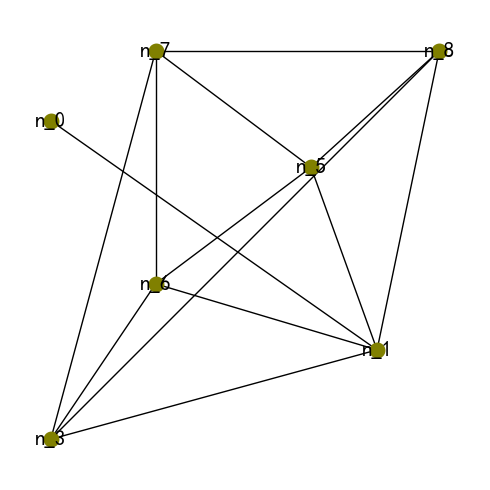

In [377]:
coords=list(partition(2,best_position))
pos=dict(zip(G.nodes, coords))
print(pos)
ann,_=usda_network.nni(coords,planning_area)    
print(ann)

usda_network.G_drawing(G,pos=pos,figsize=(5,5),node_size=20,font_size=15)

> 复杂网络更新实验是应用元启发式算法于复杂网络（图）的一次浅显探索，优化结果尚并不稳定

### 3.3.1.3 2维度布局优化 

#### 1）基于标记距离的实验

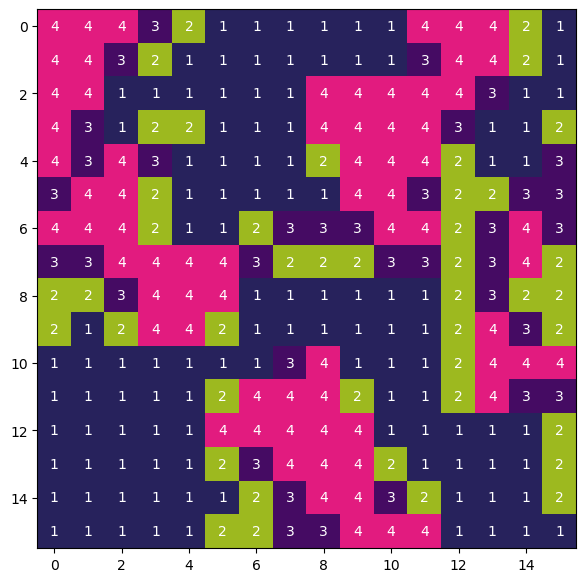

In [43]:
size=16
X,_=usda_datasets.generate_categorical_2darray(size=size,seed=99)
X4=mapclassify.FisherJenks(X[0], k=4).yb.reshape(size,size)+1
usda_vis.imshow_label2darray(X4,figsize=(7,7),random_seed=66,fontsize=10)  

In [44]:
def target_function_class_clumpSize(quadrat):
    global compared_quadradt    

    q1_cc=cc3d.connected_components(quadrat,connectivity=8,return_N=False,out_dtype=np.uint64)
    q1_cs=usda_signature.class_clumpSize_histogram(quadrat,q1_cc)   
    
    q2_cc=cc3d.connected_components(compared_quadradt, connectivity=8,return_N=False,out_dtype=np.uint64)
    q2_cs=usda_signature.class_clumpSize_histogram(compared_quadradt,q2_cc)       
    
    q1_cs_pdf=q1_cs/q1_cs.values.sum()
    q2_cs_pdf=q2_cs/q2_cs.values.sum()

    q1_cs_pdf,q2_cs_pdf=usda_utils.complete_dataframe_rowcols([q1_cs_pdf,q2_cs_pdf])     
    
    class_clumpSize_pdf_shannon=usda_signature.Distances(q1_cs_pdf.to_numpy().flatten(),q2_cs_pdf.to_numpy().flatten())
    distance=class_clumpSize_pdf_shannon.shannon()['Jensen-Shan']

    return distance

In [48]:
objects=['water','green','developed','barren']
rows_n=16
cols_n=16
compared_quadradt=copy.deepcopy(X4)

pattern_generated,epoch=usda_heuristicsw.genetic_algorithm_2d(
    objects,
    rows_n=rows_n,
    cols_n=cols_n,
    population_size=100,
    generations=501,
    mutation_rate=0.5,
    target_function=target_function_class_clumpSize,
    crossover_name='crossover_CBO',
    mutation_name='mutation_MPO_MBO', 
    mpo_mbo='mpo',
    verbose=100)

Generation = 0;	 f(x) = 0.33333318330183925
Generation = 100;	 f(x) = 0.31375270819292655
Generation = 200;	 f(x) = 0.23963574112236974
Generation = 300;	 f(x) = 0.2367642781220308
Generation = 400;	 f(x) = 0.1848457088190502
Generation = 500;	 f(x) = 0.1848457088190502


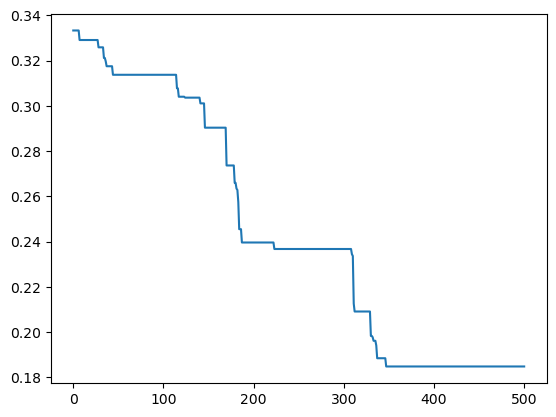

In [49]:
fig, ax=plt.subplots()
ax.plot(epoch.keys(),epoch.values())
plt.show()

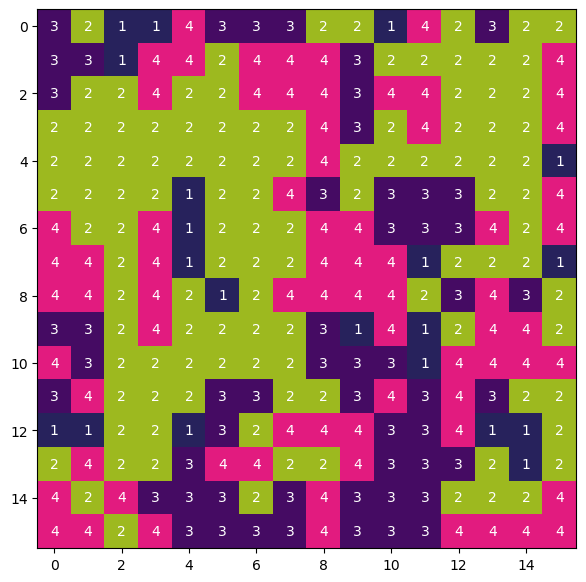

In [50]:
usda_vis.imshow_label2darray(pattern_generated+1,figsize=(7,7),random_seed=66,fontsize=10) 

## 3.3.2 元启发式算法（Meta-Heuristic Algorithm）

In [21]:
import random
from bokeh.driving import count
from bokeh.models import ColumnDataSource
from bokeh.plotting import curdoc,figure

In [24]:
update_interval=100
roll_over=100
source=ColumnDataSource({'x':[],'y':[]})

@count()
def update(x):
    y=random.random()
    source.stream({'x':[x],'y':[y]})
    
plot=figure()
plot.line('x','y',source=source)

GlyphRenderer(id='p1059', ...)